In [4]:
import os

os.environ['OPENBLAS_NUM_THREADS'] = '25'
os.environ['MKL_NUM_THREADS'] = '25'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import datetime as dt
import copy
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import xarray as xr
import pickle
import random
import time
import signal
import multiprocessing
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from scipy import interpolate
import random
import lightgbm as lgb
import itertools
import joblib
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import sys
sys.path.insert(1,'/home/jsperezc/jupyter/AQ_Forecast/functions/')
import postprocessing

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.multioutput import RegressorChain, MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit

#from gbdtmo import GBDTMulti, load_lib

# 1. Series PM2.5, AOD, IFRP

In [5]:
### PM2.5


data_pm25 = pd.read_csv('/var/data1/AQ_Forecast_DATA/historic/PM25/FullPM2.5.csv',index_col=0,parse_dates=True)
short_stations = ['SAB-JOFE','MED-UNNV','GIR-TEMP','GIR-SOSN','GIR-EPM','MED-FISC']
# data_pm25.index = data_pm25.index-dt.timedelta(hours = 1) 
data_pm25 = data_pm25.drop(short_stations,axis = 1)
stations = np.sort(data_pm25.keys())

data_pm25_orig = data_pm25
# data_pm25 = data_pm25['2017-10-01':'2020-04-01']

anomalous_stations = ['CEN-TRAF','SUR-TRAF']
df_temp = data_pm25.drop(anomalous_stations,axis = 1)

data_pm25_copy = copy.deepcopy(data_pm25) ## Copy if I have to come back
def clean_abrupt_gradient(anoms):
    diff = abs(np.diff(anoms))
    anoms[np.hstack([diff>=1.5,np.array([False])])] = np.nan
    anoms[np.hstack([np.array([False]),diff>=1.5])] = np.nan
    return pd.Series(anoms,index = anoms.index)
df_mean = pd.DataFrame(data_pm25.drop(anomalous_stations,axis = 1).mean(axis = 1))
data_temp = copy.deepcopy(df_mean)
df_mean = data_temp
df_mean.columns = ['PM25_stations']


### CAMS

data_CAMS = postprocessing.call_files('CAMS')
data_CAMS = postprocessing.recorte_espacial(data_CAMS)

dataset_full = data_CAMS

lat_cams = dataset_full.latitude.values
lon_cams = dataset_full.longitude.values

aod = np.nanmean(dataset_full.aod550.values,axis = (1,2))#[:].data
bcaod = np.nanmean(dataset_full.bcaod550.values,axis = (1,2))#[:].data
pm2p5_cams = np.nanmean(dataset_full.pm2p5.values,axis = (1,2)) #* 1000_000_000

# df_cams = pd.DataFrame(np.array([aod,bcaod,pm2p5_cams]).T,index= dataset_full.time.values,
#     columns = ['aod','bcaod','pm2p5_cams'])
df_cams = pd.DataFrame(np.array([aod,bcaod]).T,index= dataset_full.time.values,
    columns = ['aod','bcaod'])
# df_cams = (df_cams.rolling(3,center=True).mean())
df_cams.index = df_cams.index - dt.timedelta(hours = 5)


df_CAMS_hourly = df_cams.resample('H').mean().interpolate(method = 'linear',order = 3)
df_CAMS_hourly.index = df_CAMS_hourly.index

df_hourly_chem = pd.concat([df_mean,df_CAMS_hourly],axis=1)#.dropna()

Text(0, 0.5, '[$\\mu g /m^3$]')

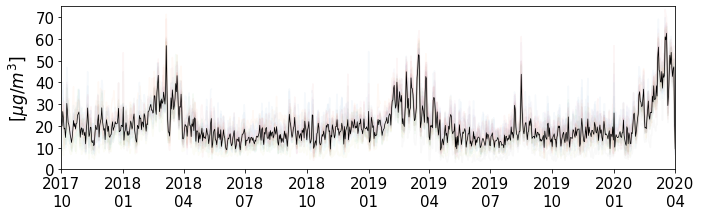

In [6]:
fig = plt.figure(figsize=(11,3))
ax = fig.add_subplot(111)
for key in data_pm25.drop(['CEN-TRAF','SUR-TRAF'],axis=1).keys():
    plt.plot(data_pm25[key].resample('D').mean(),alpha = 0.04)
    


plt.plot(df_hourly_chem.PM25_stations.resample('D').mean(),color='k',lw = 0.7)

# plt.plot(df_hourly_chem.pm2p5_cams.resample('D').mean(),color='darkorange',lw = 0.7,alpha=0.5)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(0,75)
plt.xlim(dt.datetime(2017,10,1),dt.datetime(2020,4,1))
# plt.axvline(dt.datetime(2017,10,1),ls = '--',color = 'k')
# plt.axvline(dt.datetime(2020,3,1),ls = '--',color = 'k')
# plt.fill_betweenx([0,200],dt.datetime(2014,1,1),dt.datetime(2017,10,1),color='k',alpha=0.1)
plt.fill_betweenx([0,200],dt.datetime(2020,4,1),dt.datetime(2021,2,1),color='k',alpha=0.1)
plt.fill_betweenx([0,200],dt.datetime(2021,2,1),dt.datetime(2021,5,1),color='r',alpha=0.1,ls='--')

myFmt = DateFormatter('%Y\n%m')
ax.xaxis.set_major_formatter(myFmt)

# plt.fill_betweenx([0,200],dt.datetime(2021,5,1),dt.datetime(2022,1,1),color='k',alpha=0.1)
plt.ylabel('[$\mu g /m^3$]',fontsize=17)
#plt.savefig('Figures/TimeSeries_PM_xticks.png',bbox_inches='tight')

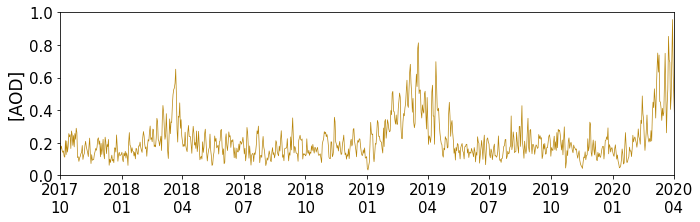

In [4]:
fig = plt.figure(figsize=(11,3))
ax = fig.add_subplot(111)
# for key in data_pm25.drop(['CEN-TRAF','SUR-TRAF'],axis=1).keys():
#     plt.plot(data_pm25[key].resample('D').mean(),alpha = 0.04)
    
plt.plot(df_hourly_chem.aod.resample('D').mean(),color='darkgoldenrod',lw = 0.7)
# plt.plot(df_hourly_chem2.aod.resample('D').mean()['2021-01':],color='darkgoldenrod',lw = 0.7)
# plt.plot(df_hourly_chem.omaod.resample('D').mean(),color='mediumseagreen',lw = 0.7,alpha=0.5)
# plt.plot(df_hourly_chem.ssaod.resample('D').mean(),color='gray',lw = 0.7,alpha=0.5)
# plt.plot(df_hourly_chem.bcaod.resample('D').mean(),color='black',lw = 0.7,alpha=0.5)
# plt.plot(df_hourly_chem2.bcaod.resample('D').mean()['2021-01':],color='black',lw = 0.7,alpha=0.5)
# plt.plot(df_hourly_chem.duaod.resample('D').mean(),color='darkorange',lw = 0.7,alpha=0.5)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(0,1)
plt.xlim(dt.datetime(2017,10,1),dt.datetime(2020,4,1))
# plt.axvline(dt.datetime(2017,10,1),ls = '--',color = 'k')
# plt.axvline(dt.datetime(2020,3,1),ls = '--',color = 'k')
# plt.fill_betweenx([0,200],dt.datetime(2014,1,1),dt.datetime(2017,10,1),color='k',alpha=0.1)
plt.fill_betweenx([0,200],dt.datetime(2020,4,1),dt.datetime(2021,2,1),color='k',alpha=0.1)
plt.fill_betweenx([0,200],dt.datetime(2021,2,1),dt.datetime(2021,5,1),color='r',alpha=0.1,ls='--')
# plt.fill_betweenx([0,200],dt.datetime(2021,5,1),dt.datetime(2022,1,1),color='k',alpha=0.1)

myFmt = DateFormatter('%Y\n%m')
ax.xaxis.set_major_formatter(myFmt)

plt.ylabel('[AOD]',fontsize=17)
plt.savefig('Figures/TimeSeries_AOD_xticks.png',bbox_inches='tight')

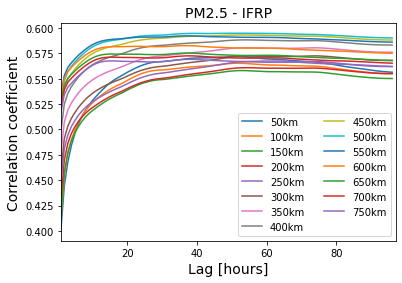

In [7]:
ifrp = pd.read_csv("/var/data1/AQ_Forecast_DATA/historic/Fires/Processed/IFRP_Radios_800hpa_4dias.csv", 
                   usecols=[str(i) for i in np.arange(16)],index_col=0,parse_dates=True)
ifrp.index = ifrp.index-dt.timedelta(hours=5)
ifrp.columns = np.arange(50, 800, 50).astype(str)


for val in ifrp.columns:
    ifrp_temp = ifrp[[val]]

    corrs_temp = []
    for lag in range(1,97):
        df_roll = ifrp_temp[val].rolling(lag).mean()
        conc = pd.concat([df_roll,df_hourly_chem.PM25_stations],axis=1).dropna()
    #     corrs_temp.append(stats.spearmanr(conc.iloc[:,0],conc.iloc[:,1]).correlation)
        corrs_temp.append(np.corrcoef(conc.iloc[:,0],conc.iloc[:,1])[0,1])

    plt.plot(np.arange(1,97),corrs_temp,label=val+'km')
    plt.legend(ncol=2)
    plt.title('PM2.5 - IFRP',fontsize=14)
    plt.xlabel('Lag [hours]',fontsize=14)
    plt.ylabel('Correlation coefficient',fontsize=14)
    plt.xlim(1,97)
plt.show()

ifrp_optimal_50 = ifrp[['50']].rolling(24).mean()

Text(0, 0.5, '[$MW$]')

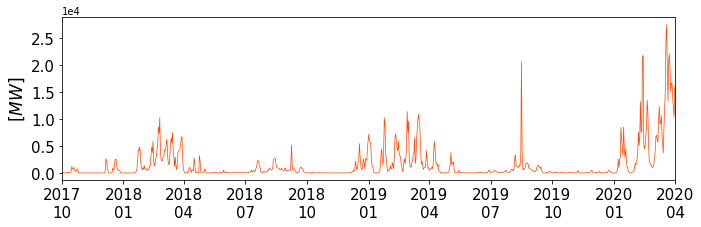

In [8]:
fig = plt.figure(figsize=(11,3))
ax = fig.add_subplot(111)
# for key in data_pm25.drop(['CEN-TRAF','SUR-TRAF'],axis=1).keys():
#     plt.plot(data_pm25[key].resample('D').mean(),alpha = 0.04)
    
# plt.plot(df_GFS_hourly.tcc.resample('D').mean(),color='blue',lw = 0.7)
plt.plot(ifrp_optimal_50.resample('D').mean(),color='orangered',lw = 0.7)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.ylim(0,525000)
plt.xlim(dt.datetime(2017,10,1),dt.datetime(2020,4,1))
plt.ticklabel_format(axis='y', style='sci', scilimits=(4,4))
# plt.axvline(dt.datetime(2017,10,1),ls = '--',color = 'k')
# plt.axvline(dt.datetime(2020,3,1),ls = '--',color = 'k')
# plt.fill_betweenx([0,200],dt.datetime(2014,1,1),dt.datetime(2017,10,1),color='k',alpha=0.1)
# plt.fill_betweenx([0,525000],dt.datetime(2020,4,1),dt.datetime(2021,2,1),color='k',alpha=0.1)
# plt.fill_betweenx([0,525000],dt.datetime(2021,2,1),dt.datetime(2021,5,1),color='r',alpha=0.1,ls='--')
# plt.fill_betweenx([0,200],dt.datetime(2021,5,1),dt.datetime(2022,1,1),color='k',alpha=0.1)

myFmt = DateFormatter('%Y\n%m')
ax.xaxis.set_major_formatter(myFmt)


plt.ylabel('[$MW$]',fontsize=17)
#plt.savefig('Figures/TimeSeries_IFRP.png',bbox_inches='tight')

In [ ]:
plt.plot(df_hourly_chem.PM25_stations)

<Axes: >

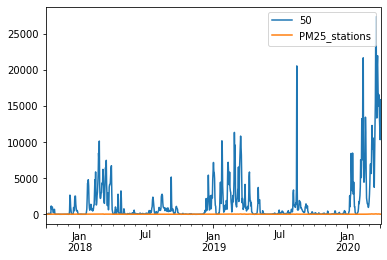

In [31]:
total = pd.concat([ifrp_optimal_50.resample('D').mean(), df_hourly_chem.PM25_stations.resample('D').mean()], axis=1)
total.dropna(how = "any",inplace=True)
total.plot()

In [32]:
total.corr()

,50,PM25_stations
50,1.00000,0.69227
PM25_stations,0.69227,1.00000


In [33]:
from scipy import stats
stats.spearmanr(total['PM25_stations'],total["50"])

SignificanceResult(statistic=0.4891672557639006, pvalue=4.24443386137659e-56)

In [36]:
stats.pearsonr(total['PM25_stations'],total["50"])

PearsonRResult(statistic=0.6922703077839327, pvalue=3.2388996661882674e-131)